In [1]:
import jax
from jax import lax, random, numpy as jnp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state

# import haiku as hk

import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = nn.Dense(features=5)

print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


In [3]:
# Step 1: init
seed = 23
key1, key2 = random.split(random.PRNGKey(seed))
x = random.normal(key1, (10,)) # dummy inpuy, a 10-dimensional random vector

# Initialization call - this gives the actual model weights
y, params = model.init_with_output(key2, x)
print(y)
print(jax.tree.map(lambda x: x.shape, params))

[-1.2137767  -0.3663314   0.06677872 -2.0143979  -0.32107335]
{'params': {'bias': (5,), 'kernel': (10, 5)}}


In [4]:
# Step 2: apply
y = model.apply(params, x)  # this is how is running prediiton in Flax, state is external
print(y)

[-1.2137767  -0.3663314   0.06677872 -2.0143979  -0.32107335]


In [5]:
try:
  y = model(x)
except Exception as e:
  print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


# Training a linear regression model

In [6]:
n_samples = 150
x_dim = 2
y_dim = 1
noise_amplitude = 0.1

key, w_key, b_key = random.split(random.PRNGKey(seed), num=3)
W = random.normal(w_key, (x_dim, y_dim))
b = random.normal(b_key, (y_dim,))

# This is the structure that Flax expects
true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise
key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))
print(f"xs shape = {xs.shape} ; ys shape = {ys.shape}")


xs shape = (150, 2) ; ys shape = (150, 1)


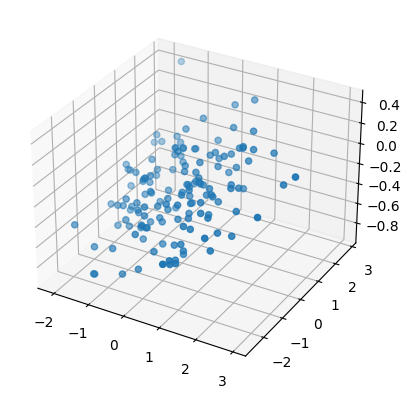

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

In [8]:
def make_mse_loss(xs, ys):

  def mse_loss(params):
    """Gives the value of the loss on the (xs, ys) dataset for the given model (params)."""

    # Define the squared loss for a sinle pair (x, y)
    def squared_error(x, y):
      pred = model.apply(params, x)
      # Inner because 'y' could have in genreal more then 1 dims
      return jnp.inner(y-pred, y-pred) / 2.0

    # Batched version via vmap
    return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)

  return jax.jit(mse_loss)  # jit the result (mse_loss is a pure function)

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)

In [9]:
model = nn.Dense(features=y_dim)
params = model.init(key, xs)
print(f"Initial params = {params}")

lr = 1e-3
epochs = 20
log_period_epoch = 5

print('-'*50)
for epoch in range(epochs):
  loss, grads = value_and_grad_fn(params)
  # SGD
  params = jax.tree.map(lambda p, g: p - lr * g, params, grads)

  if epoch % log_period_epoch == 0:
    print(f"epoch {epoch}, loss = {loss}")

print('-'*50)
print(f"Learned params = {params}")
print(f"Gt params = {true_params}")


Initial params = {'params': {'kernel': Array([[1.1737938 ],
       [0.41188157]], dtype=float32), 'bias': Array([0.], dtype=float32)}}
--------------------------------------------------
epoch 0, loss = 0.6607971787452698
epoch 5, loss = 0.6542537808418274
epoch 10, loss = 0.6477754712104797
epoch 15, loss = 0.6413618922233582
--------------------------------------------------
Learned params = {'params': {'bias': Array([-0.00422967], dtype=float32), 'kernel': Array([[1.1518111],
       [0.4080331]], dtype=float32)}}
Gt params = FrozenDict({
    params: {
        bias: Array([-0.25356248], dtype=float32),
        kernel: Array([[0.08546512],
               [0.22107157]], dtype=float32),
    },
})


In [10]:
# Now with optimizers
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)  # 3 always the same pattern - handling state externally
print(opt_state)

(EmptyState(), EmptyState())


In [11]:
params = model.init(key, xs)  # start with fresh params

for epoch in range(epochs):
  loss, grads = value_and_grad_fn(params)
  updates, opt_state = opt_sgd.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  if epoch % log_period_epoch == 0:
    print(f"epoch {epoch}, loss = {loss}")

epoch 0, loss = 0.6607971787452698
epoch 5, loss = 0.6542537808418274
epoch 10, loss = 0.6477754712104797
epoch 15, loss = 0.6413618922233582


In [12]:
opt_adam = optax.adam(learning_rate=lr)
opt_state = opt_adam.init(params)
print(opt_state)

(ScaleByAdamState(count=Array(0, dtype=int32), mu={'params': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.]], dtype=float32)}}, nu={'params': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
       [0.]], dtype=float32)}}), EmptyState())


In [13]:
params = model.init(key, xs)

for epoch in range(epochs):
  loss, grads = value_and_grad_fn(params)
  updates, opt_state = opt_adam.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  if epoch % log_period_epoch == 0:
    print(f"epoch {epoch}, loss = {loss}")

epoch 0, loss = 0.6607971787452698
epoch 5, loss = 0.6532472968101501
epoch 10, loss = 0.6457734107971191
epoch 15, loss = 0.6383804678916931


In [14]:
class MLP(nn.Module):
  num_neurons_per_layer: Sequence[int]

  def setup(self):
    self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

  def __call__(self, x):
    activation = x
    for i, layer in enumerate(self.layers):
      activation = layer(activation)
      if i != len(self.layers) - 1:
        activation = nn.relu(activation)

    return activation

x_key, init_key = random.split(random.PRNGKey(seed))

model = MLP(num_neurons_per_layer=[16, 8, 1])
x = random.uniform(x_key, (4, 4))  # dummy input
params = model.init(init_key, x)
y = model.apply(params, x)

print(jax.tree.map(jnp.shape, params))
print(f"Output: {y}")

{'params': {'layers_0': {'bias': (16,), 'kernel': (4, 16)}, 'layers_1': {'bias': (8,), 'kernel': (16, 8)}, 'layers_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[0.3599736 ]
 [0.19171566]
 [0.3277179 ]
 [0.46014392]]


# Introducing "param"

In [15]:
class MyDenseImp(nn.Module):
  num_neurons: int
  weight_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros

  @nn.compact
  def __call__(self, x):
    weight = self.param('weight',  # parameter name
                        self.weight_init,  # initialization function, RNG passed implicitly through init fn
                        (x.shape[-1], self.num_neurons))  # shape info
    bias = self.param('bias', self.bias_init, (self.num_neurons,))

    return jnp.dot(x, weight) + bias

x_key, init_key = random.split(random.PRNGKey(seed))


model = MyDenseImp(num_neurons=3)  # initialize the model
x = random.uniform(x_key, (4, 4))  # dummy input
params = model.init(init_key, x)   # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f'Output: {y}')

{'params': {'bias': (3,), 'weight': (4, 3)}}
Output: [[-0.4543119   0.14070597 -0.1399677 ]
 [-0.32604304 -0.02913585  0.21127704]
 [-0.16531758  0.2607744  -0.37982285]
 [-0.01778072  0.40737242 -0.1099543 ]]


In [16]:
from inspect import signature

print(signature(nn.initializers.lecun_normal()))

(key: 'KeyArray', shape: 'core.Shape', dtype: 'DTypeLikeInexact' = <class 'jax.numpy.float64'>) -> 'Array'


# Introducing "variable"

In [17]:
class BiasAdderWithRunningMean(nn.Module):
  decay: float = 0.99

  @nn.compact
  def __call__(self, x):
    is_initialized = self.has_variable('batch_stats', 'ema')

    # Flax uses that name in its implementation of BatchNorm
    ema = self.variable('batch_stats', 'ema', lambda shape: jnp.zeros(shape), x.shape[1:])

    bias = self.param('bias', lambda key, shape: jnp.zeros(shape), x.shape[1:])

    if is_initialized:
      # sel.variable return a reference hence .value
      ema.value = self.decay * ema.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

    return x - ema.value + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = random.uniform(x_key, (10, 4))  # dummy uniform
variables = model.init(init_key, x)
print(f"Multiple collections = {variables}")

y, updated_non_trainable_params = model.apply(variables, x, mutable=['batch_stats'])
print(updated_non_trainable_params)

Multiple collections = {'batch_stats': {'ema': Array([0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0.], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.00421787, 0.00597094, 0.00638907, 0.00699901]], dtype=float32)}}


In [18]:
# def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):

#     def loss_fn(params):
#         y, updated_non_trainable_params = apply_fn(
#             {'params': params, **non_trainable_params},
#             x, mutable=list(non_trainable_params.keys()))

#         loss = ((x - y) ** 2).sum()  # not doing anything really, just for the demo purpose

#         return loss, updated_non_trainable_params

#     (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
#     updates, opt_state = opt.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)

#     return opt_state, params, non_trainable_params  # all of these represent the state - ugly, for now

# model = BiasAdderWithRunningMean()
# x = jnp.ones((10,4))  # dummy input, using ones because it's easier to see what's going on

# variables = model.init(random.PRNGKey(seed), x)
# non_trainable_params, params = variables.pop('params', None), variables
# del variables  # delete variables to avoid wasting resources (this pattern is used in the official code)

# sgd_opt = optax.sgd(learning_rate=0.1)  # originally you'll see them use the 'tx' naming (from opTaX)
# opt_state = sgd_opt.init(params)

# for _ in range(3):
#     # We'll later see how TrainState abstraction will make this step much more elegant!
#     opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
#     print(non_trainable_params)

In [19]:
class DDNBlock(nn.Module):
  num_neurons: int
  training: bool

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(self.num_neurons)(x)
    x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
    x = nn.BatchNorm(use_running_average=not self.training)(x)
    return x

key1, key2, key3, key4 = random.split(random.PRNGKey(seed), 4)

model = DDNBlock(num_neurons=3, training=True)
x = random.uniform(key1, (3, 4, 4))

# New
variables = model.init({'params': key2, 'dropout': key3}, x)
print(variables)

y, non_trainable_params = model.apply(variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

eval_model = DDNBlock(num_neurons=3, training=False)
y = eval_model.apply(variables, x)

{'params': {'Dense_0': {'kernel': Array([[-0.7563737 ,  0.01997766,  0.04605455],
       [ 0.65764475, -0.7379195 , -0.3011639 ],
       [ 0.80684876,  0.7780826 ,  0.09813767],
       [ 0.1541389 ,  0.17243949,  0.44406676]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}, 'BatchNorm_0': {'scale': Array([1., 1., 1.], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, 'batch_stats': {'BatchNorm_0': {'mean': Array([0., 0., 0.], dtype=float32), 'var': Array([1., 1., 1.], dtype=float32)}}}


 A fully-fledged CNN on MNIST example in Flax

In [20]:
class CNN(nn.Module):  # lots of hardcoding, but it serves a purpose for a simple demo
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x


In [21]:
def custom_transform(x):
  # Input: (28, 28) uint8 [0, 255] torch.Tensor, Output: (28, 28, 1) float32 [0, 1] np array
  return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
  """Provided us with batches of numpy arrays and not PyTorch's tensors."""
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.stack(transposed_data[0])

  return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
test_images = jnp.array(test_dataset.targets)

test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5437960.02it/s]


Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 157002.63it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 311143.46it/s]


Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2516250.00it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5432197.05it/s]


Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158719.53it/s]


Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1512066.86it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3752320.03it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



7


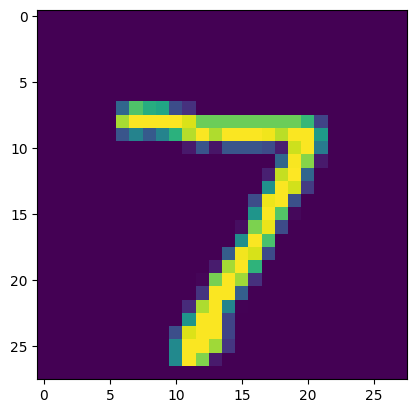

In [22]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(gt_lbl)
plt.imshow(img); plt.show()

# Core training function

In [23]:
@jax.jit
def train_step(state, imgs, gt_labels):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, imgs)
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))

  (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
  state = state.apply_gradients(grads=grads)  # this is the whole upate now
  metrics = compute_metrics(logits=logits, gt_labels=gt_labels)
  return state, metrics

@jax.jit
def eval_step(state, imgs, gt_labels):
  logits = CNN().apply({'params', state.params}, imgs)
  return compute_metrics(lgoits=logits, gt_labels=gt_labels)

In [27]:
def train_one_epoch(state, dataloader, epoch):
  """Train for 1 epoch on the training set"""
  batch_metrics = []
  for cnt, (imgs, labels) in enumerate(dataloader):
    state, metrics = train_step(state, imgs, labels)
    batch_metrics.append(metrics)

  # Aggregate the metrics
  batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
  epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

  return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_lbls):
  """Evaluate on the validation set."""
  metrics = eval_step(state, test_imgs, test_lbls)
  metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
  metrics = jax.tree.map(lambda x: x.item(), metrics)
  return metrics

In [35]:


# This one will keep things nice and tidy compared to our previous examples
def create_train_state(key, learning_rate, momentum):
    cnn = CNN()
    params = cnn.init(key, jnp.ones([1, *mnist_img_size]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    # TrainState is a simple built-in wrapper class that makes things a bit cleaner
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=sgd_opt)

def compute_metrics(*, logits, gt_labels):
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics



In [38]:
seed = 0  # needless to say these should be in a config or defined like flags
learning_rate = 0.1
momentum = 0.9
num_epochs = 2
batch_size = 32

train_state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state, test_images, test_lbls)
    print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")

AttributeError: 'TrainState' object has no attribute 'TrainState'